# **Trabajo Practico 1 - Aprendisaje Automatico 2 - TUIA**


---

# **Enunciado**

## **Descripción:**
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

---

## **Dataset:**  
**Link:** https://drive.google.com/file/d/1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ/view?usp=drive_link  
  
El dataset proporcionado contiene alrededor de **25,000 imágenes** de tamaño **150x150**, distribuidas en **seis categorías**:  
*  🏢 **buildings**  
*  🌲 **forest**
*  🧊 **glacier**
*  ⛰️ **mountain**  
*  🌊 **sea**  
*  🛣️ **street**    


Las imágenes están divididas en **3 conjuntos**:  
*  **Train:** Alrededor de **14,000** imágenes para entrenamiento.  
*  **Test:** Alrededor de **3,000** imágenes para evaluación del modelo.  
*  **Prediction:** Alrededor de **7,000** imágenes para predicción final.

---

## **Objetivo:**
Utilizando el dataset proporcionado, el objetivo es **construir y comparar el rendimiento de distintos modelos de clasificación de imágenes** utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.
Los modelos a diseñar son:
*  **Modelo con capas densas.**
*  **Modelo con capas convolucionales y densas.**
*  **Modelo que incluya bloques residuales identidad:** Bloque residual identidad

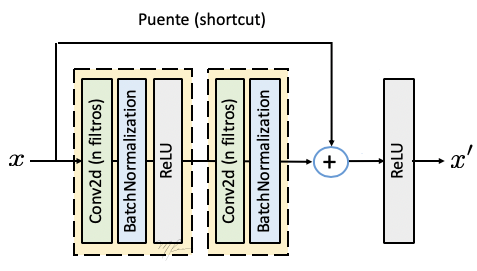

*  **Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow** (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications  


Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

---

## **Entrega:**
La entrega debe incluir:
**Código fuente** de la solución implementada en Google **Colab**, que incluya:
*  Análisis previo y preprocesamiento del set de datos.
*  Definición y entrenamiento del modelo.
*  Resultados de la evaluación del modelo, incluyendo métricas de desempeño y visualizaciones relevantes.

**Nota:** el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.

---

# **Preparación del entorno**

## **Librerias necesarias**

In [ ]:
# Importaciones

# Generales
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import shutil
from pathlib import Path
import pandas as pd
import random
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

# Data augmentation
from tensorflow.keras.layers import RandomFlip, RandomTranslation, RandomContrast

# Regularizacion
from tensorflow.keras.layers import Dropout

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Red Densa
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Flatten, Dense

# Red Convolucional
from keras.layers import Input, BatchNormalization
from keras.layers import Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D

# Red Residual
from keras.layers import Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Red Transfer Learning


# Instalaciones
!apt-get install tree -qq

Selecting previously unselected package tree.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


---

## **Habilitación GPU**

In [ ]:
# Configuracion para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


---

## **Descarga dataset**

In [ ]:
# Creamos la carpeta destino
!mkdir -p dataset

# Descargamos el ZIP desde Google Drive
!gdown "https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ" -O dataset/dataset.zip

# Descomprimimos el ZIP en una carpeta
!unzip -q dataset/dataset.zip -d dataset

# Eliminamos el ZIP
os.remove("dataset/dataset.zip")

# Definimos nuevos nombres para las carpetas
mapeo_carpetas = {
    "seg_train": "train",
    "seg_test": "test",
    "seg_pred": "prediction"
}

# Renombramos las 3 carpetas y eliminamos subcarpeta duplicada
for viejo, nuevo in mapeo_carpetas.items():
  carpeta_externa = os.path.join("dataset", viejo)
  carpeta_interna = os.path.join(carpeta_externa, viejo)

  if os.path.exists(carpeta_interna):
      for nombre in os.listdir(carpeta_interna):
          origen = os.path.join(carpeta_interna, nombre)
          destino = os.path.join(carpeta_externa, nombre)
          shutil.move(origen, destino)

      os.rmdir(carpeta_interna)

  if os.path.exists(carpeta_externa):
      os.rename(carpeta_externa, os.path.join("dataset", nuevo))

# Mostramos la distribucion de carpetas
print("\nEstructura dataset:\n")
!tree dataset -d -L 2

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=04b2e0a0-d10e-49a4-b976-0d2c4ceb8d56
To: /content/dataset/dataset.zip
100% 363M/363M [00:06<00:00, 54.3MB/s]

Estructura dataset:

dataset
├── prediction
├── test
│   ├── buildings
│   ├── forest
│   ├── glacier
│   ├── mountain
│   ├── sea
│   └── street
└── train
    ├── buildings
    ├── forest
    ├── glacier
    ├── mountain
    ├── sea
    └── street

15 directories


**Interpretación:**   
El dataset está organizado en tres carpetas principales: train, test y prediction. Las carpetas train y test contienen subcarpetas para cada clase (buildings, forest, glacier, mountain, sea y street)

---

# **Análisis exploratorio de datos**

## **Muestra dataset**

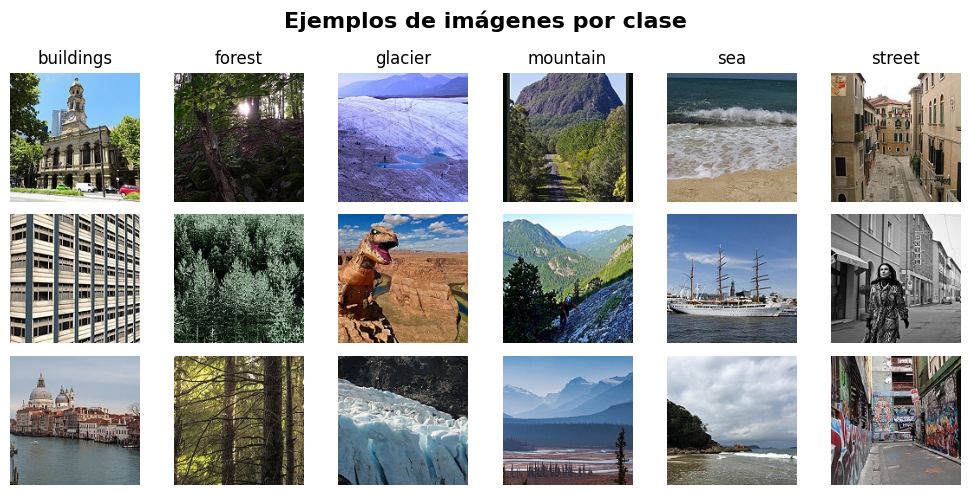

In [ ]:
train_dir = "dataset/train"
clases = sorted(os.listdir(train_dir))

fig, axes = plt.subplots(3, 6, figsize=(10, 5))
fig.suptitle('Ejemplos de imágenes por clase', fontsize=16, fontweight='bold')

for i, clase in enumerate(clases):
    images = sorted(os.listdir(os.path.join(train_dir, clase)))
    random_images = np.random.choice(images, 3, replace=False)

    for j, img_nombre in enumerate(random_images):
        img = mpimg.imread(os.path.join(train_dir, clase, img_nombre))
        ax = axes[j, i]
        ax.imshow(img)
        ax.axis('off')
        if j == 0:
            ax.set_title(clase, fontsize=12)

plt.tight_layout()
plt.show()

**Observación:**  
Las imágenes de cada clase son variadas, lo que ayuda a que el modelo aprenda mejor. Sin embargo, algunas clases presentan similitudes visuales que podrían dificultar la clasificación. Por ejemplo:

*  Las clases **glacier** y **mountain** comparten paisajes con formaciones rocosas y nieve.

*  Las clases **street** y **buildings** pueden mostrar estructuras urbanas similares, como veredas, personas o fachadas de edificios.

Estas similitudes pueden generar confusiones durante el entrenamiento o en la predicción.

## **Formato imágen**

In [ ]:
def procesar_imagen(img_path, new_size, extensiones):
    """Procesa una sola imagen, redimensiona y convierte a RGB si es necesario."""
    try:
        img = Image.open(img_path)

        # Obtener la extensión y agregarla al conjunto
        extension = os.path.splitext(img_path)[-1].lower()
        extensiones.add(extension)

        imagen_redimensionada = False
        imagen_convertida_rgb = False

        # Solo redimensionar si la imagen no tiene el tamaño correcto
        if img.size != new_size:
            img = img.resize(new_size)
            imagen_redimensionada = True

        # Convertir a RGB si no lo está
        if img.mode != "RGB":
            img = img.convert("RGB")
            imagen_convertida_rgb = True

        img.save(img_path)
        return imagen_redimensionada, imagen_convertida_rgb

    except Exception as e:
        print(f"No se pudo procesar {img_path}: {e}")
        return False, False

def redimensionar_formatear_imagenes(dataset_dir, new_size=(150, 150), flat=False):
    """Procesa un directorio de imágenes, ya sea con o sin subcarpetas."""
    cant_tamanio_incorrecto = 0
    cant_modo_incorrecto = 0
    extensiones = set()

    if flat:
        for img_nombre in os.listdir(dataset_dir):
            img_path = os.path.join(dataset_dir, img_nombre)
            redim, no_rgb = procesar_imagen(img_path, new_size, extensiones)
            if redim:
                cant_tamanio_incorrecto += 1
            if no_rgb:
                cant_modo_incorrecto += 1
    else:
        for clase in os.listdir(dataset_dir):
            clase_dir = os.path.join(dataset_dir, clase)
            if os.path.isdir(clase_dir):
                for img_nombre in os.listdir(clase_dir):
                    img_path = os.path.join(clase_dir, img_nombre)
                    redim, no_rgb = procesar_imagen(img_path, new_size, extensiones)
                    if redim:
                        cant_tamanio_incorrecto += 1
                    if no_rgb:
                        cant_modo_incorrecto += 1

    print("\nResumen del formato del dataset:")
    print(f"- Imágenes redimensionadas a {new_size}: {cant_tamanio_incorrecto}")
    print(f"- Imágenes convertidas a RGB: {cant_modo_incorrecto}")
    print(f"- Extensiones encontradas: {', '.join(extensiones)}")


# Ejemplo de uso:

# Redimensionamos y formateamos las imágenes en los directorios 'train' y 'test' (con subcarpetas)
print("Procesando imagens de train...")
redimensionar_formatear_imagenes('dataset/train', flat=False)
print("\nProcesando imagens de test...")
redimensionar_formatear_imagenes('dataset/test', flat=False)


# Redimensionamos y formateamos las imágenes en el directorio 'prediction' (sin subcarpetas)
print("\nProcesando imagens de prediction...")
redimensionar_formatear_imagenes('dataset/prediction', flat=True)


Procesando imagens de train...

Resumen del formato del dataset:
- Imágenes redimensionadas a (150, 150): 48
- Imágenes convertidas a RGB: 0
- Extensiones encontradas: .jpg

Procesando imagens de test...

Resumen del formato del dataset:
- Imágenes redimensionadas a (150, 150): 7
- Imágenes convertidas a RGB: 0
- Extensiones encontradas: .jpg

Procesando imagens de prediction...

Resumen del formato del dataset:
- Imágenes redimensionadas a (150, 150): 13
- Imágenes convertidas a RGB: 0
- Extensiones encontradas: .jpg


In [ ]:
# Mostramos el formato de las imagenes
image_path = 'dataset/train/buildings/0.jpg'

with Image.open(image_path) as img:
    width, height = img.size
    mode = img.mode
    file_extension = os.path.splitext(image_path)[1]

    # Imprimimos la información
    print("Formato de las imágenes:\n")
    print(f"Tamaño (Shape): {width}x{height}")
    print(f"Modo (Color): {mode}")
    print(f"Extensión del archivo: {file_extension}")


Formato de las imágenes:

Tamaño (Shape): 150x150
Modo (Color): RGB
Extensión del archivo: .jpg


## **Balanceo dataset**

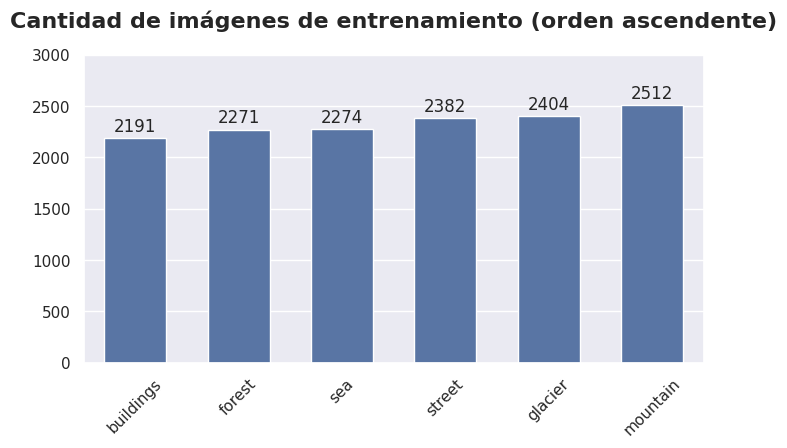

In [ ]:
train_dir = 'dataset/train'

# Obtenemos la lista de clases (carpetas)
clases = sorted(os.listdir(train_dir))
contador_clases = {}

# Contamos las imágenes por clase
for nombre_clase in clases:
    class_path = os.path.join(train_dir, nombre_clase)
    image_count = len(os.listdir(class_path))
    contador_clases[nombre_clase] = image_count

# Ordenamos las clases de menor a mayor según el conteo
clases_ordenadas = sorted(contador_clases.items(), key=lambda x: x[1])
clases_ordenadas = dict(clases_ordenadas)  # Convertimos de lista de tuplas a diccionario

# Gráfico de barras ordenado
plt.figure(figsize=(8, 4))

sns.set_theme(style="darkgrid")
ax = sns.barplot(
    x=list(clases_ordenadas.keys()),
    y=list(clases_ordenadas.values()),
    width=0.6,
    order=clases_ordenadas.keys()  # ¡Clave para ordenar las barras!
)

# Añadir los valores sobre las barras
ax.bar_label(ax.containers[0], label_type='edge', padding=2, fmt='%d')

plt.title('Cantidad de imágenes de entrenamiento (orden ascendente)', pad=20, fontsize=16, fontweight='bold')
plt.yticks(range(0, max(contador_clases.values()) + 501, 500))
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linewidth=1)

plt.show()

**Interpretación:**   
Cada clase cuenta con aproximadamente 2300 imágenes de entrenamiento, con un rango que va de 2191 (**buildings**) a 2512 (**mountain**). Esta diferencia representa una variación de alrededor del **15 %** entre la clase con menor y mayor cantidad de ejemplos. Por lo tanto, se puede concluir que el **dataset está relativamente balanceado**.

## **Distribución de colores**

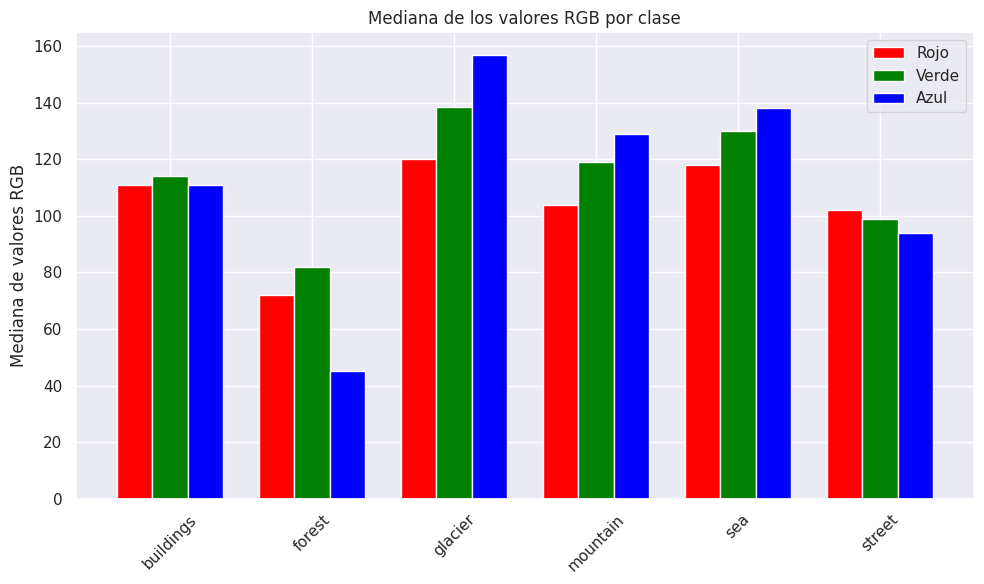

In [ ]:
# Directorio de imágenes
train_dir = "dataset/train"
clases = sorted(os.listdir(train_dir))

# Crear listas para almacenar los valores promedio de cada canal por clase
medianas_rojo = []
medianas_verde = []
medianas_azul = []

for clase in clases:
    # Obtener todas las imágenes de la clase
    imagenes_clase = os.listdir(os.path.join(train_dir, clase))

    # Inicializar acumuladores para los valores RGB
    rojo = []
    verde = []
    azul = []

    for img_nombre in imagenes_clase:
        img_path = os.path.join(train_dir, clase, img_nombre)

        # Leer la imagen
        img = mpimg.imread(img_path)

        # Asegurarnos de que la imagen es RGB
        if img.shape[2] == 3:
            rojo.append(np.median(img[:, :, 0]))  # Mediana de canal rojo
            verde.append(np.median(img[:, :, 1]))  # Mediana de canal verde
            azul.append(np.median(img[:, :, 2]))  # Mediana de canal azul

    # Mediana de los valores RGB para la clase
    medianas_rojo.append(np.median(rojo))
    medianas_verde.append(np.median(verde))
    medianas_azul.append(np.median(azul))

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Posiciones para las barras
posiciones = np.arange(len(clases))

# Ancho de las barras
ancho = 0.25

# Barras para cada canal (Rojo, Verde, Azul)
ax.bar(posiciones - ancho, medianas_rojo, width=ancho, label='Rojo', color='red')
ax.bar(posiciones, medianas_verde, width=ancho, label='Verde', color='green')
ax.bar(posiciones + ancho, medianas_azul, width=ancho, label='Azul', color='blue')

# Etiquetas y título
ax.set_xticks(posiciones)
ax.set_xticklabels(clases, rotation=45)
ax.set_ylabel('Mediana de valores RGB')
ax.set_title('Mediana de los valores RGB por clase')
ax.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

**Interpretación cada clase**  

*  **🏢 Buildings:** Los colores están bastante parejos, lo que encaja con fotos de ciudades o construcciones, donde predominan materiales como cemento o ladrillo.

*  **🌲 Forest:** El verde es el que más aparece, como era de esperarse en un bosque. El azul queda bien abajo, así que no hay mucho cielo ni agua en estas imágenes.

*  **🧊 Glacier:** Gana el azul por lejos, lo que tiene sentido en paisajes fríos con hielo o nieve. También hay algo de verde, quizás por reflejos o zonas rocosas.

*  **⛰️ Mountain:** Los colores están bastante equilibrados, pero con un poquito más de azul. Puede ser por presencia de agua, cielo despejado o sombras frías de las montañas.

*  **🌊 Sea:** Mucho azul, algo de verde y menos rojo. Representa bien imágenes del mar, con agua en primer plano y quizá algo de vegetación.

*  **🛣️ Street:** Los valores son similares entre sí, aunque el azul es el más bajo. Probablemente sean calles, autos y edificios, con poca naturaleza o cielo.

**Interpretación general:**  
En general, los colores predominantes en cada clase coinciden con lo que uno esperaría: mucho verde en forest, azul en glacier y sea, y una mezcla más pareja en buildings y street. Esto indica que las imágenes están bien agrupadas y reflejan bastante bien el tipo de paisaje que representan.

---

# **Entrenamiento de modelos**

## **Preparación del dataset**

In [ ]:
# Directorio de los datos de entrenamiento
DATA_DIRECTORY = Path("dataset/train")

# Tamaño del lote (batch size)
BATCH_SIZE = 64

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

In [ ]:
# Carga los datos de entrenamiento y validación

print("\nCargando conjunto de train...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

print("\nCargando conjunto de validación...")

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)


# Cargar las imágenes de test
print("\nCargando conjunto de test...")

# Directorio de los datos de test
TEST_DIRECTORY = Path("dataset/test")

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIRECTORY,
    label_mode="categorical",  # Etiquetas en formato categórico (one-hot encoded)
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # Tamaño de las imágenes
    batch_size=BATCH_SIZE,  # Tamaño del batch
)


Cargando conjunto de train...
Found 14034 files belonging to 6 classes.
Using 11228 files for training.

Cargando conjunto de validación...
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.

Cargando conjunto de test...
Found 3000 files belonging to 6 classes.


In [ ]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Nombre de las clases: ",class_names)

Nombre de las clases:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


---

## **Funciones útiles**

**Gráfico métricas entrenamiento**

In [ ]:
def graficar_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(7, 6))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

**Muestra predicciones**

In [ ]:
def mostrar_predicciones_aleatorias(prediction_dir, model, clases, n_imagenes=6):
    # Obtenemos la lista de imágenes en el directorio de predicciones
    imagenes = sorted(os.listdir(prediction_dir))

    # Seleccionamos n imágenes aleatorias
    imagenes_seleccionadas = random.sample(imagenes, n_imagenes)

    # Creamos el gráfico con 2 filas y 3 columnas (se ajusta a n_imagenes)
    filas = n_imagenes // 3
    columnas = 3
    fig, axes = plt.subplots(filas, columnas, figsize=(10, 6))
    fig.suptitle('Predicciones de imágenes aleatorias', fontsize=16, fontweight='bold')

    for i, img_nombre in enumerate(imagenes_seleccionadas):
        img_path = os.path.join(prediction_dir, img_nombre)
        img = mpimg.imread(img_path)

        # Redimensionamos la imagen
        img = Image.open(img_path)
        img = np.array(img)  # Convertimos la imagen a un array para que sea compatible con el modelo

        # Realizamos la predicción (asegurándonos de que las imágenes sean preprocesadas correctamente)
        prediccion = model.predict(np.expand_dims(img, axis=0))
        prediccion_clase = clases[np.argmax(prediccion)]  # Asumimos que 'clases' tiene el mismo orden que las clases en el modelo

        # Posición en el subplot
        ax = axes[i // columnas, i % columnas]  # Calcula la posición en el subplot
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Predicción: {prediccion_clase}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajusta para no solaparse con el título
    plt.show()

**Entrenamiento**

In [ ]:
def entrenar_modelo(model, train_ds, val_ds, epochs=70, paciencia=10, umbral_acc=0.7):

    # Compilamos
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=paciencia,
        verbose=1,
        mode="min"
    )

    checkpoint_acc = ModelCheckpoint(
        "best_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        initial_value_threshold=umbral_acc,
        mode="max",
        verbose=0
    )

    # Entrenamos
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=[checkpoint_acc, early_stopping]
    )

    return history


**Calculo de y_true e y_pred**

In [ ]:
def obtener_etiquetas_y_predicciones(model, test_ds):
    """Función para obtener las etiquetas verdaderas y las predicciones del modelo."""
    # Inicializamos las listas para las etiquetas verdaderas y las predicciones
    y_true = []
    y_pred = []

    # Iteramos sobre el dataset de test para recolectar las etiquetas y las predicciones
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)  # Predicciones del modelo

        # Las predicciones se convierten en índices de la clase con la mayor probabilidad
        y_pred.extend(np.argmax(preds, axis=1))

        # Las etiquetas verdaderas (one-hot) se convierten también a índices
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    return y_true, y_pred

**Reporte de métricas y matriz de confusión**

In [ ]:
def reporte_y_matriz_conf(modelo, dataset, class_names):
    # Obtener etiquetas verdaderas y predichas
    y_true, y_pred = obtener_etiquetas_y_predicciones(modelo, dataset)

    # Reporte completo
    reporte = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # F1-score por clase
    f1_por_clase = {clase: reporte[clase]['f1-score'] for clase in class_names}

    # Matriz de confusión
    matriz_conf = confusion_matrix(y_true, y_pred)

    # Graficar matriz de confusión
    plt.figure(figsize=(7, 5))
    sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión')
    plt.show()

    return f1_por_clase

**Almacenamiento de métricas**

In [ ]:
resultados = {}

---

## **Red densa**

### **Definición**

In [ ]:
model = Sequential([
    Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)), # Antes no estaba
    # Normalizacion
    Rescaling(1./255),

    # Data Augmentation
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    RandomTranslation(0.1, 0.1, fill_mode="reflect"),
    RandomContrast(0.2),

    # Red Densa
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    17,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,321,798 (66.08 MB)

 Trainable params: 17,321,798 (66.08 MB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento**

In [ ]:
history = entrenar_modelo(model,
                          train_ds,
                          val_ds,
                          epochs=80,
                          paciencia=15)

Epoch 1/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.2779 - loss: 5.8509 - val_accuracy: 0.3624 - val_loss: 1.8904
Epoch 2/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4199 - loss: 1.6096 - val_accuracy: 0.4647 - val_loss: 1.3649
Epoch 3/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4317 - loss: 1.5733 - val_accuracy: 0.4544 - val_loss: 1.4207
Epoch 4/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4646 - loss: 1.3996 - val_accuracy: 0.5285 - val_loss: 1.2688
Epoch 5/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4935 - loss: 1.3281 - val_accuracy: 0.4786 - val_loss: 1.3699
Epoch 6/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4960 - loss: 1.3262 - val_accuracy: 0.5403 - val_loss: 1.2011
Epoch 7/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5001 - loss: 1.3013 - val_accuracy: 0.5285 - val_loss: 1.2345
Epoch 8/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5065 - loss: 1.2829 - val_acc

---

### **Métricas entrenamiento**

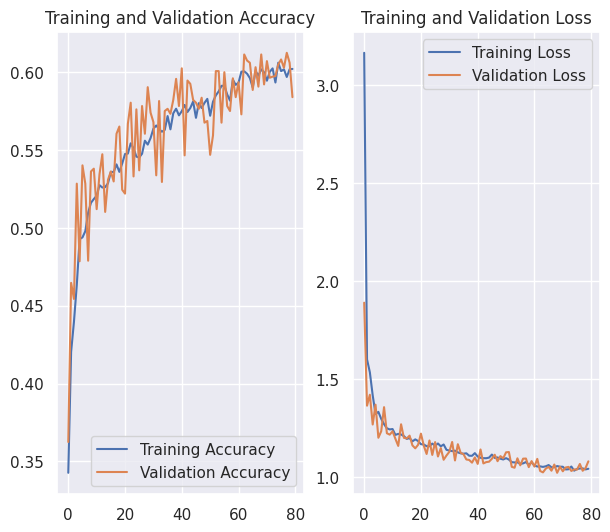

In [ ]:
graficar_acc_loss(history)

**Interpretación:**  

El entrenamiento fue bastante estable. La precisión de entrenamiento y validación fueron mejorando juntas, sin separarse mucho, lo que indica que no hay overfitting. La pérdida también bajó rápido al principio y luego se mantuvo pareja. En general, el modelo aprendió bien y de forma consistente, llegando a valores de accuracy cercanos al 60% y una pérdida alrededor de 1.

**Observación:**  
Probamos una red con 128 | 64 | 32 neuronas, obteniendo una precisión de aproximadamente 0.57/0.59 en entrenamiento y validación. Con la red actual, de 256 | 128 | 64 neuronas (el doble de tamaño), logramos una precisión de 0.61/0.62 en ambas métricas. Dependiendo del contexto y el uso previsto para este modelo, podríamos optar por una de estas dos arquitecturas: si no se dispone de tanto poder de cómputo, la primera opción sería más adecuada, mientras que si se cuenta con recursos suficientes, la segunda podría ofrecer mejores resultados.

---

### **Evaluación de métricas en test**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
test_loss = round(test_loss, 3)
test_accuracy = round(test_accuracy, 3)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5788 - loss: 1.1163
Test Loss: 1.134
Test Accuracy: 0.567


              precision    recall  f1-score   support

   buildings       0.58      0.27      0.37       437
      forest       0.69      0.81      0.74       474
     glacier       0.48      0.80      0.60       553
    mountain       0.71      0.47      0.57       525
         sea       0.50      0.28      0.36       510
      street       0.54      0.73      0.62       501

    accuracy                           0.57      3000
   macro avg       0.58      0.56      0.54      3000
weighted avg       0.58      0.57      0.55      3000



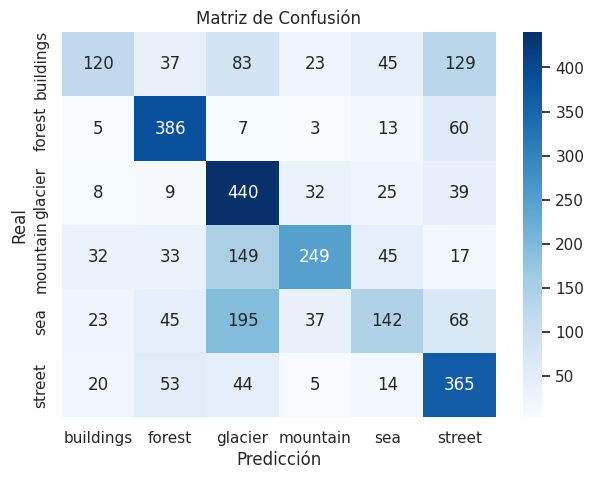

In [ ]:
f1_por_clase = reporte_y_matriz_conf(model, test_ds, class_names)

**Interpretación**  
Este modelo tiene dificultades para diferenciar correctamente algunas clases. En particular:

- **Glacier** y **mountain** se mezclan seguido. Es entendible, porque ambas muestran paisajes parecidos, con nieve, piedras y colores similares.

- La clase **sea** fue una de las que más confundió. En muchos casos la tomó por **glacier** o **mountain**, quizás porque tienen cielos abiertos, agua o tonos parecidos.

- También se confunde seguido **street** con **buildings**, ya que las dos muestran escenas de ciudad, con calles, edificios y autos.

- Por otro lado, **forest** parece ser más fácil de reconocer para el modelo, ya que casi no se equivoca con esa clase.

En general, al modelo le cuesta notar los detalles que hacen diferente a cada tipo de imagen.


In [ ]:
# Guardamos los resultados y matriz de confusion
resultados["Densa"] = {
    'epochs': len(history.history['loss']),
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'f1-buildings': f1_por_clase['buildings'],
    'f1-forest': f1_por_clase['forest'],
    'f1-glacier': f1_por_clase['glacier'],
    'f1-mountain': f1_por_clase['mountain'],
    'f1-sea': f1_por_clase['sea'],
    'f1-street': f1_por_clase['street']
}

### **Predicciones**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


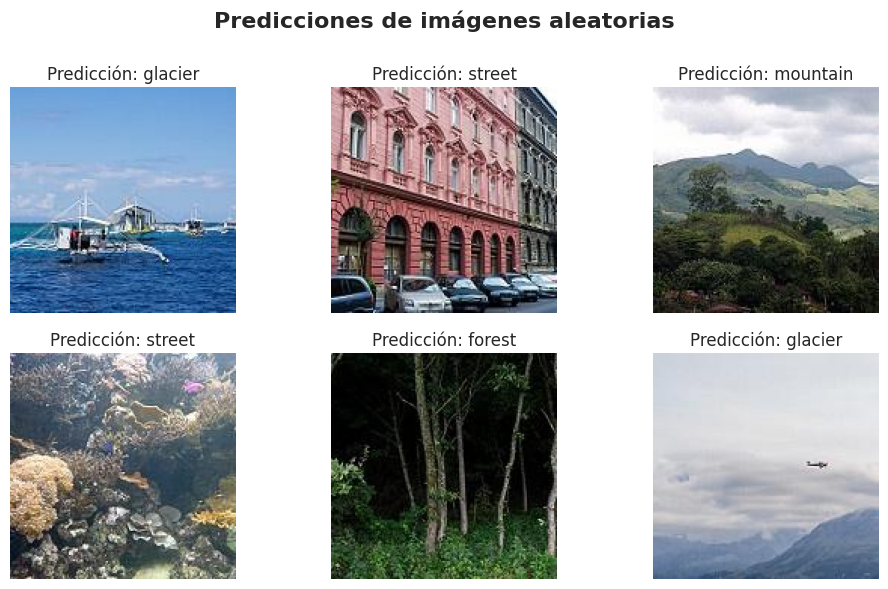

In [ ]:
mostrar_predicciones_aleatorias('dataset/prediction', model, class_names)

---

## **Red Convolucional**

### **Definición**

In [ ]:
model = Sequential([
    # Normalizacion
    Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

    # Data Augmentation (solo si querés dentro del modelo)
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    RandomTranslation(0.1, 0.1, fill_mode="reflect"),
    RandomContrast(0.2),

    # Red convolucional
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,582 (8.10 MB)

 Trainable params: 2,122,582 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento**

In [ ]:
history = entrenar_modelo(model,
                          train_ds,
                          val_ds,
                          epochs=40,
                          paciencia=10)

Epoch 1/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.4268 - loss: 1.3632 - val_accuracy: 0.6404 - val_loss: 0.9327
Epoch 2/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6386 - loss: 0.9311 - val_accuracy: 0.6999 - val_loss: 0.7756
Epoch 3/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.6827 - loss: 0.8231 - val_accuracy: 0.7662 - val_loss: 0.6230
Epoch 4/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7134 - loss: 0.7548 - val_accuracy: 0.7605 - val_loss: 0.6254
Epoch 5/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7357 - loss: 0.7113 - val_accuracy: 0.7833 - val_loss: 0.6054
Epoch 6/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7525 - loss: 0.6748 - val_accuracy: 0.7758 - val_loss: 0.6258
Epoch 7/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7577 - loss: 0.6590 - val_accuracy: 0.8172 - val_loss: 0.5219
Epoch 8/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7637 - loss: 0.6338 - val_

### **Métricas entrenamiento**

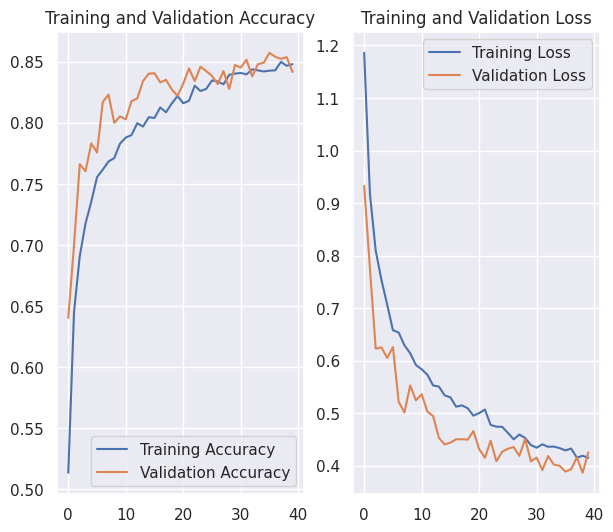

In [ ]:
graficar_acc_loss(history)

**Interpretación:**

El modelo tuvo un entrenamiento muy bueno. La precisión subió rápido y se mantuvo alta tanto en entrenamiento como en validación, sin mostrar overfitting. La pérdida bajó de forma constante y pareja en ambas curvas. En general, el modelo aprendió de forma efectiva, llegando a una accuracy cercana al 85% y una pérdida alrededor de 0.4.

### **Métricas test**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
test_loss = round(test_loss, 3)
test_accuracy = round(test_accuracy, 3)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8497 - loss: 0.4238
Test Loss: 0.443
Test Accuracy: 0.847


              precision    recall  f1-score   support

   buildings       0.93      0.70      0.80       437
      forest       0.92      0.99      0.96       474
     glacier       0.78      0.84      0.81       553
    mountain       0.83      0.77      0.80       525
         sea       0.86      0.86      0.86       510
      street       0.80      0.92      0.85       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



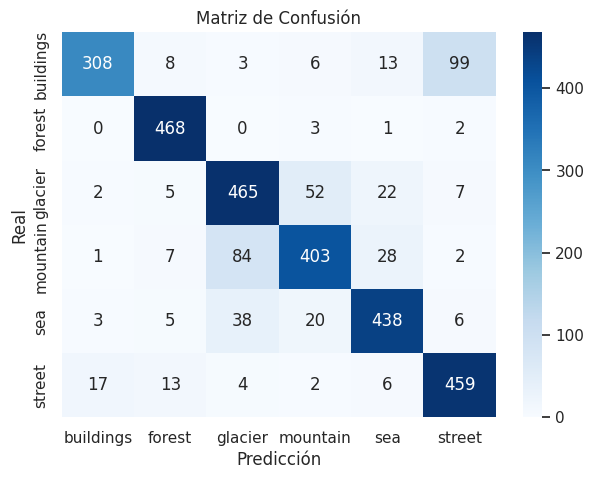

In [ ]:
f1_por_clase = reporte_y_matriz_conf(model, test_ds, class_names)

**Interpretación:**  

Este modelo funciona bastante bien en general, ya que acierta con la mayoría de las imágenes.

- A veces se confunde con clases que se parecen. Por ejemplo, mezcla **mountain** con **glacier**, que tienen paisajes similares con nieve y rocas.

- También se equivoca entre **street** y **buildings**, lo cual tiene sentido porque ambas muestran escenas urbanas con calles, autos y construcciones.

- En cambio, **forest** es una de las clases que mejor reconoce, con pocos errores.

En resumen, el modelo hace un buen trabajo, aunque todavía le cuesta diferenciar algunas categorías que visualmente se parecen mucho entre sí.


In [ ]:
# Guardamos los resultados y matriz de confusion
resultados["Convolucional"] = {
    'epochs': len(history.history['loss']),
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'f1-buildings': f1_por_clase['buildings'],
    'f1-forest': f1_por_clase['forest'],
    'f1-glacier': f1_por_clase['glacier'],
    'f1-mountain': f1_por_clase['mountain'],
    'f1-sea': f1_por_clase['sea'],
    'f1-street': f1_por_clase['street']
}

### **Predicciones**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


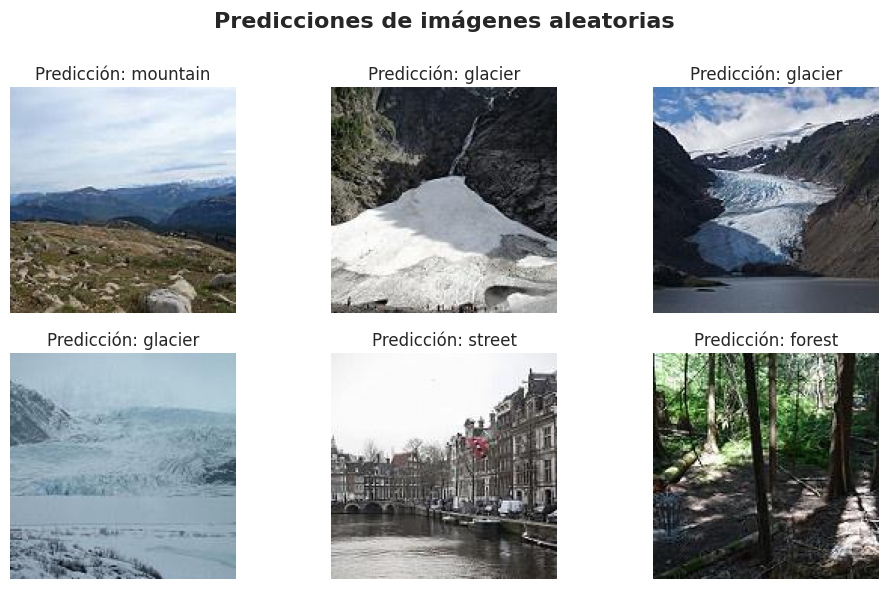

In [ ]:
mostrar_predicciones_aleatorias('dataset/prediction', model, class_names)

---

## **Red Residual - ResNet**

### **Definición**

In [ ]:
def residual_block(x, filters, downsample=False):
    shortcut = x

    strides = (2, 2) if downsample else (1, 1)

    # Rama principal
    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Proyección si las dimensiones no coinciden
    if shortcut.shape[-1] != filters or downsample:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        # shortcut = BatchNormalization()(shortcut)

    # Suma
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [ ]:
def resNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Normalización y data augmentation
    x = Rescaling(1./255)(inputs)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Bloques convolucionales con residuales
    x = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
    x = residual_block(x, 16, downsample=True)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 32, downsample=True)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64, downsample=True)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = resNet((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 150, 150,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_4       │ (None, 150, 150,  │          0 │ rescaling_2[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_5       │ (None, 150, 150,  │          0 │ random_flip_4[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 150, 150,  │          0 │ random_flip_5[0]… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_2   │ (None, 150, 150,  │          0 │ random_translati… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 150, 150,  │        224 │ random_contrast_… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 75, 75,    │      1,168 │ conv2d_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 75, 75,    │         64 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 75, 75,    │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │         64 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 75, 75,    │        144 │ conv2d_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 75, 75,    │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 37, 37,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 19, 19,    │      4,640 │ max_pooling2d_3[

 Total params: 110,390 (431.21 KB)

 Trainable params: 109,942 (429.46 KB)

 Non-trainable params: 448 (1.75 KB)

### **Entrenamiento**

In [ ]:
history = entrenar_modelo(model,
                          train_ds,
                          val_ds,
                          epochs=35,
                          paciencia=10)

Epoch 1/35
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.3836 - loss: 1.7575 - val_accuracy: 0.1625 - val_loss: 3.6119
Epoch 2/35
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.6017 - loss: 0.9909 - val_accuracy: 0.1828 - val_loss: 3.5359
Epoch 3/35
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6738 - loss: 0.8496 - val_accuracy: 0.4547 - val_loss: 1.5826
Epoch 4/35
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.7217 - loss: 0.7368 - val_accuracy: 0.5242 - val_loss: 1.4350
Epoch 5/35
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7473 - loss: 0.6879 - val_accuracy: 0.7890 - val_loss: 0.5609
Epoch 6/35
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.7635 - loss: 0.6386 - val_accuracy: 0.7541 - val_loss: 0.6337
Epoch 7/35
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7819 - loss: 0.6024 - val_accuracy: 0.7420 - val_loss: 0.6865
Epoch 8/35
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7848 - loss: 0.5904 - v

### **Métricas entrenamiento**

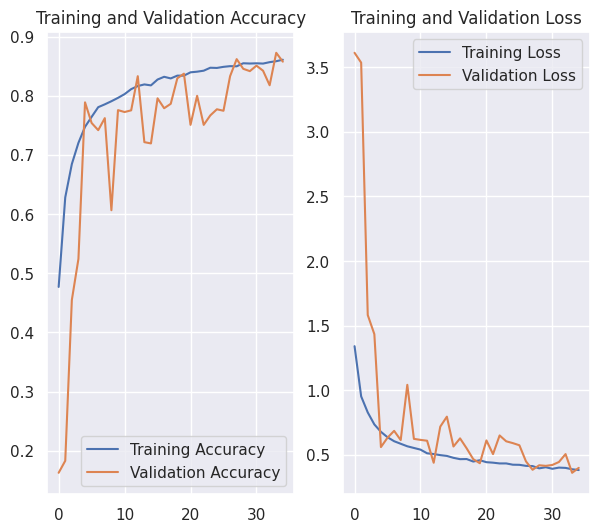

In [ ]:
graficar_acc_loss(history)

**Interpretación:**

El modelo tuvo un entrenamiento muy bueno. La precisión subió rápido y se mantuvo alta tanto en entrenamiento como en validación, sin mostrar sobreajuste. La pérdida bajó de forma constante y pareja en ambas curvas. En general, el modelo aprendió de forma efectiva, llegando a una accuracy cercana al 86% y una pérdida por debajo de 0.4.

### **Métricas test**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
test_loss = round(test_loss, 3)
test_accuracy = round(test_accuracy, 3)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8547 - loss: 0.4170
Test Loss: 0.439
Test Accuracy: 0.85


              precision    recall  f1-score   support

   buildings       0.85      0.84      0.85       437
      forest       0.86      0.99      0.92       474
     glacier       0.86      0.75      0.80       553
    mountain       0.78      0.85      0.81       525
         sea       0.85      0.88      0.86       510
      street       0.92      0.81      0.86       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



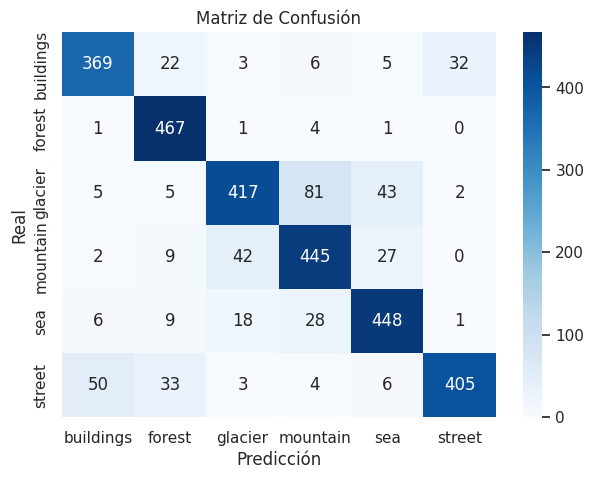

In [ ]:
f1_por_clase = reporte_y_matriz_conf(model, test_ds, class_names)

**Interpretación:**

Este modelo funciona bastante bien en general, ya que acierta con la mayoría de las imágenes. Rendimiento similar al Modelo Convolucional.

- A veces se confunde con clases que se parecen. Por ejemplo, mezcla **mountain** con **glacier**, que tienen paisajes similares con nieve y rocas.

- También se equivoca entre **street** y **buildings**, lo cual tiene sentido porque ambas muestran escenas urbanas con calles, autos y construcciones.

- En cambio, **forest** es una de las clases que mejor reconoce, con pocos errores.

En resumen, el modelo hace un buen trabajo, aunque todavía le cuesta diferenciar algunas categorías que visualmente se parecen mucho entre sí.


In [ ]:
# Guardamos los resultados
resultados["ResNet"] = {
    'epochs': len(history.history['loss']),
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'f1-buildings': f1_por_clase['buildings'],
    'f1-forest': f1_por_clase['forest'],
    'f1-glacier': f1_por_clase['glacier'],
    'f1-mountain': f1_por_clase['mountain'],
    'f1-sea': f1_por_clase['sea'],
    'f1-street': f1_por_clase['street']
}

### **Predicciones**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


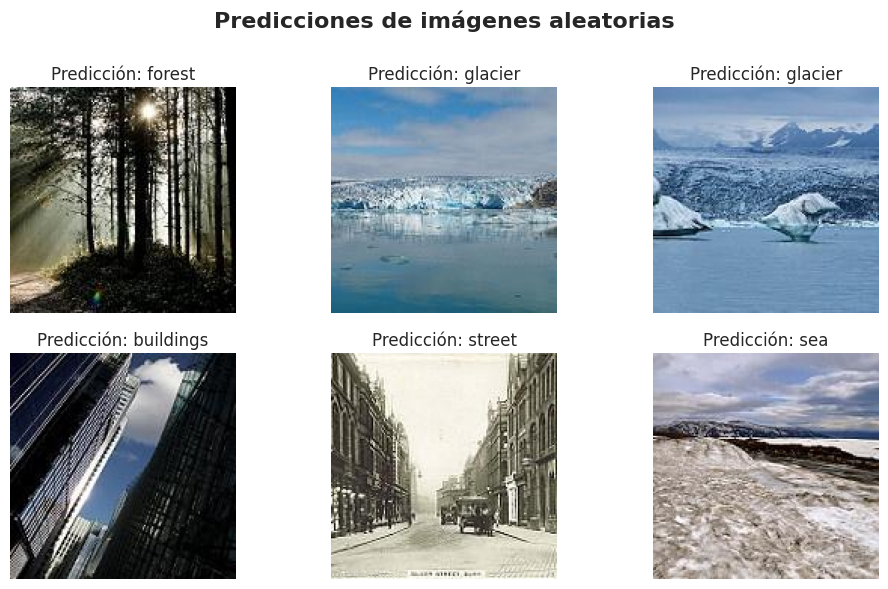

In [ ]:
mostrar_predicciones_aleatorias('dataset/prediction', model, class_names)

---

## **Red Transfer Learning**

### **Definición**

In [ ]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape, # PROBAR CON OTRO BACKBONE !!!!!!!!!!
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    # Normalización y data augmentation
    x = RandomFlip("horizontal")(i)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Backbone
    x = base_model(x, training=False)

    # Red Densa
    x = GlobalAveragePooling2D()(x) # Antes estaba en Max
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x) # Antes era 32
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model.summary()

Building model


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_19 (RandomFlip)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_20 (RandomFlip)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_10           │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_9               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,945 (15.76 MB)

 Trainable params: 82,374 (321.77 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### **Entrenamiento**

In [ ]:
history = entrenar_modelo(model,
                          train_ds,
                          val_ds,
                          epochs=30,
                          paciencia=8)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - accuracy: 0.8842 - loss: 0.3002 - val_accuracy: 0.9130 - val_loss: 0.2262
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.8899 - loss: 0.2923 - val_accuracy: 0.9170 - val_loss: 0.2169
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.8931 - loss: 0.2892 - val_accuracy: 0.9134 - val_loss: 0.2230
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.8876 - loss: 0.2936 - val_accuracy: 0.9152 - val_loss: 0.2196
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.8911 - loss: 0.2835 - val_accuracy: 0.9138 - val_loss: 0.2194
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.8965 - loss: 0.2740 - val_accuracy: 0.9227 - val_loss: 0.2112
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.9003 - loss: 0.2711 - val_accuracy: 0.9138 - val_loss: 0.2153
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9033 - loss: 0.26

### **Métricas entrenamiento**

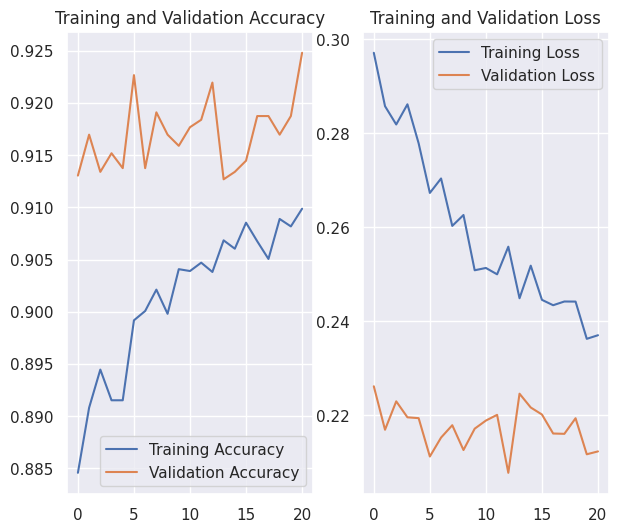

In [ ]:
graficar_acc_loss(history)

**Interpretación:**

El modelo tuvo un entrenamiento muy bueno. La precisión subió rápido y se mantuvo alta tanto en entrenamiento como en validación, sin mostrar sobreajuste. La pérdida bajó de forma constante y pareja en ambas curvas. En general, el modelo aprendió de forma efectiva, llegando a una accuracy cercana al 92% y una pérdida por debajo de 0.22.

### **Métricas test**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
test_loss = round(test_loss, 3)
test_accuracy = round(test_accuracy, 3)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9227 - loss: 0.2137
Test Loss: 0.218
Test Accuracy: 0.919


              precision    recall  f1-score   support

   buildings       0.95      0.86      0.91       437
      forest       1.00      1.00      1.00       474
     glacier       0.84      0.89      0.86       553
    mountain       0.90      0.85      0.88       525
         sea       0.96      0.95      0.96       510
      street       0.89      0.97      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



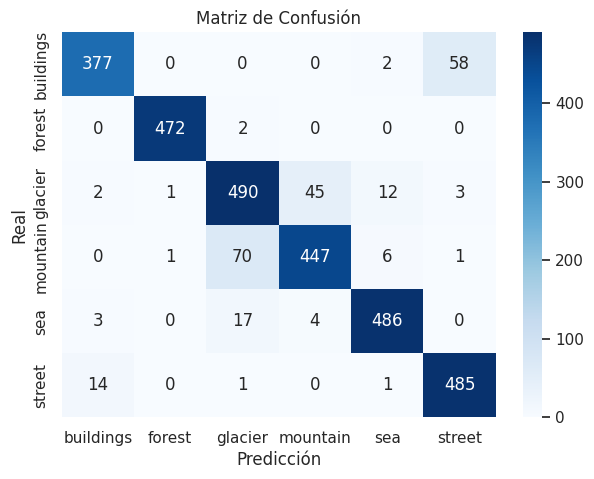

In [ ]:
f1_por_clase = reporte_y_matriz_conf(model, test_ds, class_names)

**Interpretación:**

Este modelo funciona muy bien y es el mejor de todos los que probamos hasta ahora.

- Como ya pasaba en los anteriores, sigue habiendo confusiones entre clases parecidas. Por ejemplo, glacier y mountain se mezclan bastante, lo cual tiene sentido porque ambos muestran paisajes con nieve y rocas.

- También confunde un poco buildings con street, algo esperable ya que los dos muestran escenas urbanas con estructuras y autos.

En general, el modelo hace un gran trabajo. Aunque todavía le cuesta un poco con algunas clases parecidas, el rendimiento es sólido y mejora todo lo anterior.

In [ ]:
# Guardamos los resultados
resultados["TransferLearning"] = {
    'epochs': len(history.history['loss']),
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'f1-buildings': f1_por_clase['buildings'],
    'f1-forest': f1_por_clase['forest'],
    'f1-glacier': f1_por_clase['glacier'],
    'f1-mountain': f1_por_clase['mountain'],
    'f1-sea': f1_por_clase['sea'],
    'f1-street': f1_por_clase['street']
}

### **Predicciones**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


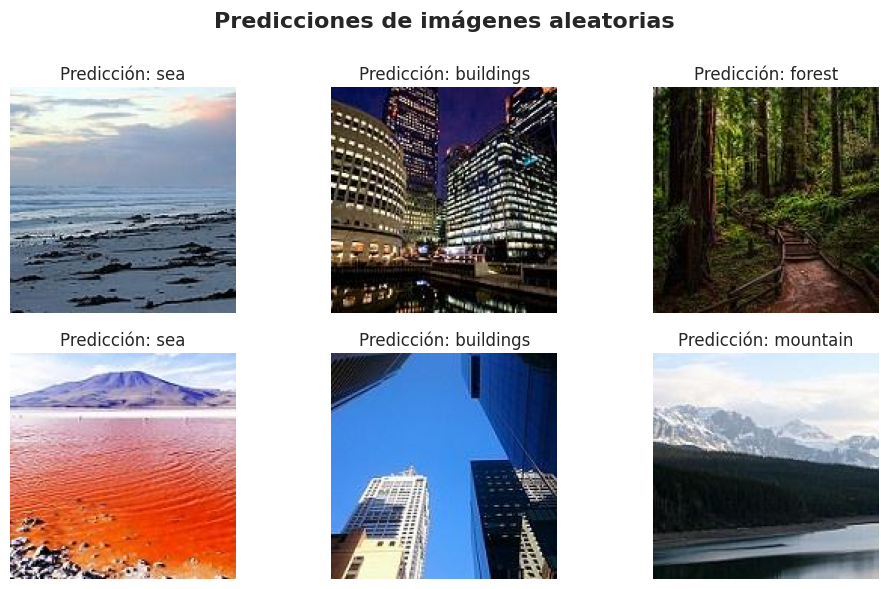

In [ ]:
mostrar_predicciones_aleatorias('dataset/prediction', model, class_names)

---

# **Comparación de modelos**

In [ ]:
df = pd.DataFrame(resultados).T.reset_index().rename(columns={"index": "modelo"})
df

modelo  epochs  test_accuracy  test_loss  f1-buildings  \
0             Densa    80.0          0.567      1.134      0.372093   
1     Convolucional    40.0          0.847      0.443      0.802083   
2            ResNet    35.0          0.850      0.439      0.848276   
3  TransferLearning    21.0          0.919      0.218      0.905162   

   f1-forest  f1-glacier  f1-mountain    f1-sea  f1-street  
0   0.744455    0.598232     0.569794  0.357683   0.619169  
1   0.955102    0.810811     0.797230  0.860511   0.853160  
2   0.916585    0.804243     0.814273  0.861538   0.860786  
3   0.995781    0.864960     0.875612  0.955752   0.925573

## **Accuracy**

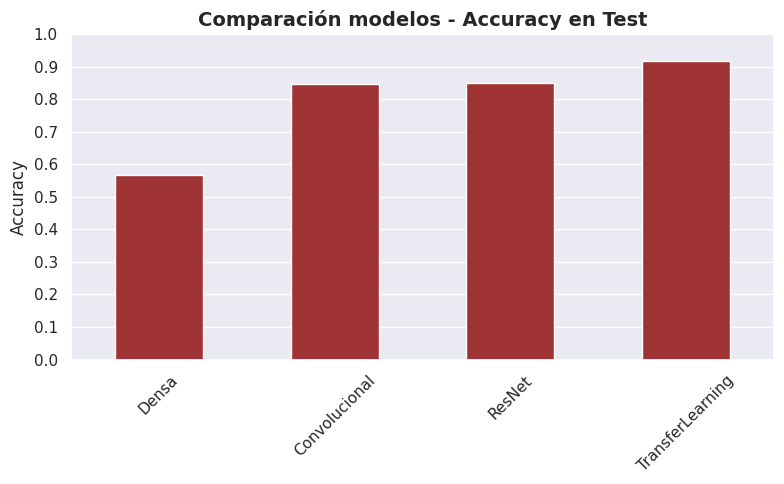

In [ ]:
# Ordenar modelos por test_accuracy de menor a mayor
orden = df.sort_values('test_accuracy')['modelo']

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='modelo', y='test_accuracy', order=orden, width=0.5, color='firebrick')
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title("Comparación modelos - Accuracy en Test", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy")
plt.xlabel("")
plt.xticks(rotation=45)  # Opcional si los nombres son largos
plt.tight_layout()
plt.show()

**Interpretación**

Este gráfico muestra qué tan bien clasificó cada modelo los datos de prueba.  
- El modelo **Denso** tuvo el peor rendimiento, con una accuracy cercana al **58%**.  
- **ResNet** y el modelo **Convolucional** tuvieron buenos resultados, ambos similares, con aproximadamente **85%** de accuracy.
- El modelo de **Transfer Learning** fue el más efectivo, alcanzando alrededor del **92%** de precisión.





## **Loss**

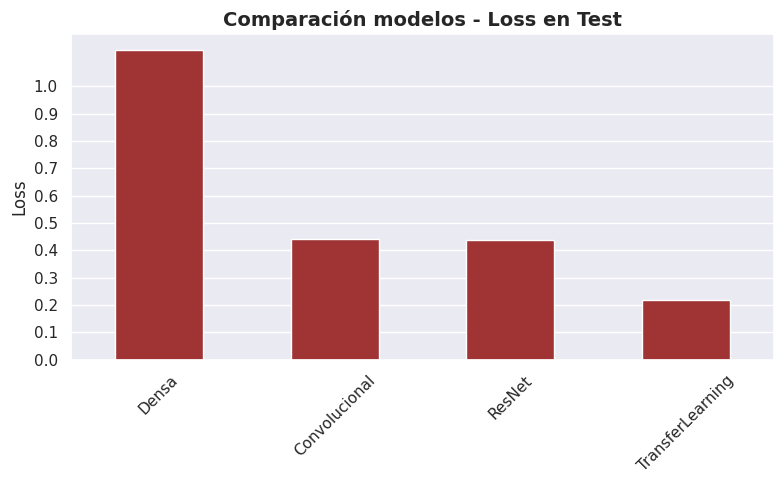

In [ ]:
# Ordenar modelos por test_accuracy de menor a mayor
orden = df.sort_values('test_loss', ascending=False)['modelo']

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='modelo', y='test_loss', order=orden, width=0.5, color='firebrick')
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title("Comparación modelos - Loss en Test", fontsize=14, fontweight='bold')
plt.ylabel("Loss")
plt.xlabel("")
plt.xticks(rotation=45)  # Opcional si los nombres son largos
plt.tight_layout()
plt.show()

**Interpretación:**  

Este gráfico refleja el nivel de error de los modelos (valores más bajos indican mejores resultados).  
- El modelo **Denso** tuvo el mayor error.  
- **ResNet** y el modelo **Convolucional** mostraron valores intermedios similares.  
- El modelo de **Transfer Learning** tuvo el menor error, lo que refuerza su buen desempeño.

## **F1-Score**

In [ ]:
dfc = df[['modelo', 'f1-buildings', 'f1-forest', 'f1-glacier', 'f1-mountain', 'f1-sea', 'f1-street']]
dfc

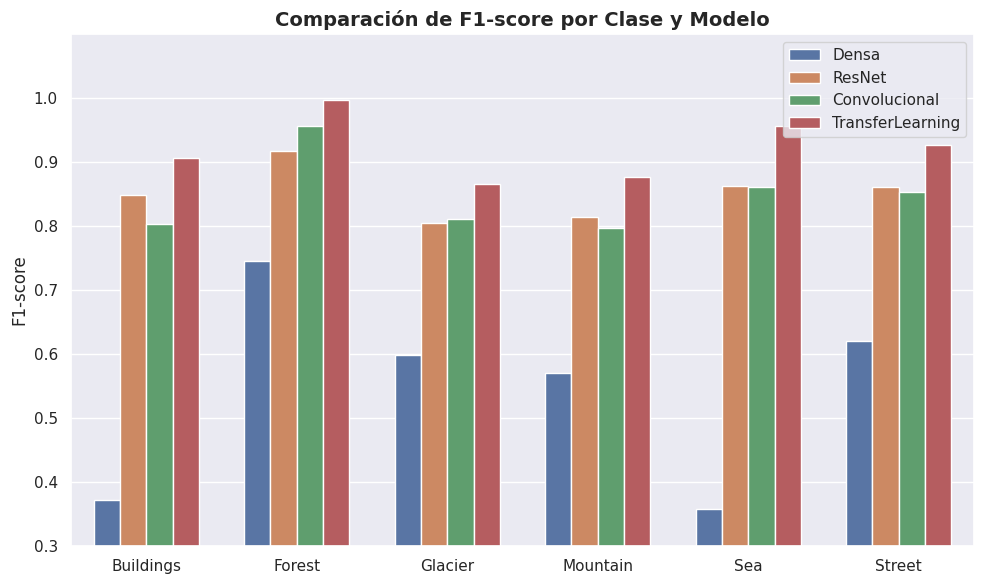

In [ ]:
dfc = df[['modelo', 'f1-buildings', 'f1-forest', 'f1-glacier', 'f1-mountain', 'f1-sea', 'f1-street']].sort_values('f1-forest')


# Transformamos el DataFrame
df_melted = dfc.melt(id_vars='modelo',
                    value_vars=[col for col in df.columns if col.startswith('f1-')],
                    var_name='Clase',
                    value_name='F1-score')

# Limpiar nombres
df_melted['Clase'] = df_melted['Clase'].str.replace('f1-', '').str.capitalize()

# Gráfico ordenado
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Clase', y='F1-score', hue='modelo', width=0.7)
plt.ylim(0.3, 1.099)
plt.title('Comparación de F1-score por Clase y Modelo', fontsize = 14, fontweight='bold')
plt.xlabel('')
plt.ylabel('F1-score')
plt.legend(title='', loc='upper right')
plt.tight_layout()
plt.show()


**Interpretación:**

Este gráfico muestra el F1-score alcanzado por cada modelo para cada clase de paisaje. Cuanto más alto el valor, mejor logró el modelo identificar correctamente las imágenes de esa clase.

- **Forest** y **Street** fueron las clases más fáciles de reconocer para todos los modelos. En especial el de Transfer Learning, que casi no falló.

- **Buildings** y **Sea** mostraron bastante diferencia entre modelos. El denso falló mucho, mientras que los más avanzados lograron buenos resultados.

- **Glacier** y **Mountain** fueron las clases más difíciles. Esto puede deberse a que visualmente se parecen mucho: ambas tienen paisajes con montañas, nieve o cielo abierto, lo que hace más difícil diferenciarlas. Aun así, Transfer Learning logró buenos resultados.

#**Conclusión**

Los resultados muestran una mejora progresiva en el rendimiento de los modelos.

- El modelo **Denso** tuvo el rendimiento más bajo, debido a su incapacidad para capturar características espaciales complejas al estar compuesto únicamente por capas densas.

- Los modelos **Convolucional y ResNet** mostraron un rendimiento similar y consistente. Resnet no supero a Convolucional, lo que puede deberse a que la versión de ResNet utilizada no era lo suficientemente profunda como para aprovechar completamente su arquitectura residual.

- Finalmente, el modelo de **Transfer Learning** fue el más preciso y consistente, destacándose en varias categorías. Su ventaja se debe a que parte de una red previamente entrenada con gran capacidad de generalización, lo que le permite obtener mejores resultados incluso con un conjunto de datos limitado.

El mejor resultado alcanzado fue una precisión del **92%**, lo cual es destacable considerando la complejidad del problema: la clasificación de seis categorías de paisajes, algunas de las cuales presentan imágenes **visualmente similares**. Esto sugiere que los **resultados obtenidos son sólidos** y que los modelos lograron aprender representaciones útiles a pesar de la dificultad del conjunto de datos.

